In [1]:
import pandas as pd
import pulp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_customers = pd.read_csv('customers.csv')
df_customers

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [3]:
df_visit = pd.read_csv('visit_probability.csv')
df_visit

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


In [4]:
dict_seg_num = pd.merge(df_customers, df_visit).groupby('segment_id')['customer_id'].count().to_dict()
df_val = df_visit.copy()
df_val['seg_customer_num'] = df_val.segment_id.map(dict_seg_num)

In [5]:
for i in range(3):
    ptn = i + 1
    df_val[f'diff_dm{ptn}'] = df_val[f'prob_dm{ptn}'] - df_val.prob_dm1
    df_val[f'val_dm{ptn}'] = [pulp.LpVariable(f'x_{i}_{ptn}',lowBound=0, upBound=1, cat='Continuous') for i in df_val.segment_id]
    #df_val[f'val_dm{ptn}'] = pulp.LpVariable.dict('x', f'{ptn}_' + df_visit.segment_id.astype('str'),
    #                                                 lowBound=0, upBound=1, cat='Continuous')
dict_cost = {1:0, 2:1000, 3:2000}

In [6]:
df_val

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3,seg_customer_num,diff_dm1,val_dm1,diff_dm2,val_dm2,diff_dm3,val_dm3
0,age~19,freq0,1,0.07,0.12,0.29,200,0.0,x_1_1,0.05,x_1_2,0.22,x_1_3
1,age~19,freq1,2,0.21,0.30,0.58,150,0.0,x_2_1,0.09,x_2_2,0.37,x_2_3
2,age~19,freq2,3,0.28,0.39,0.74,50,0.0,x_3_1,0.11,x_3_2,0.46,x_3_3
3,age~19,freq3~,4,0.35,0.45,0.77,100,0.0,x_4_1,0.10,x_4_2,0.42,x_4_3
4,age20~34,freq0,5,0.11,0.17,0.37,600,0.0,x_5_1,0.06,x_5_2,0.26,x_5_3
5,age20~34,freq1,6,0.32,0.43,0.72,450,0.0,x_6_1,0.11,x_6_2,0.40,x_6_3
6,age20~34,freq2,7,0.42,0.55,0.93,150,0.0,x_7_1,0.13,x_7_2,0.51,x_7_3
7,age20~34,freq3~,8,0.52,0.63,0.94,300,0.0,x_8_1,0.11,x_8_2,0.42,x_8_3
8,age35~49,freq0,9,0.08,0.14,0.33,800,0.0,x_9_1,0.06,x_9_2,0.25,x_9_3
9,age35~49,freq1,10,0.25,0.35,0.67,600,0.0,x_10_1,0.10,x_10_2,0.42,x_10_3


In [7]:
cost_list = []
cpa_list = []
inc_action_list = []

In [8]:
def calc(budget):

    problem = pulp.LpProblem('coupon2', pulp.LpMaximize)

    problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'diff_dm{m}'] * r.seg_customer_num 
                        for m in [2,3] for _,r in df_val.iterrows()])

    for _, r in df_val.iterrows():
        problem += pulp.lpSum([r[f'val_dm{m}'] for m in [1,2,3]]) == 1
        for m in [1,2,3]:
            problem += r[f'val_dm{m}'] >= 0.1

    problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'prob_dm{m}'] * r.seg_customer_num * dict_cost[m] 
                        for m in [2,3] for _,r in df_val.iterrows()]) <= budget
    status = problem.solve()
    return pulp.LpStatus[status], pulp.value(problem.objective)

In [9]:
for cost in range(761_850, 3_000_000, 100_000):
    status, value = calc(cost)
    if status != 'Optimal':
        raise("Not optimal")
    cost_list.append(cost)
    cpa_list.append(cost/value)
    inc_action_list.append(value)
    print(status, cost_list[-1], inc_action_list[-1], cpa_list[-1]) 

Optimal 761850 229.00000000000006 3326.8558951965056
Optimal 861850 273.0571427200001 3156.2990494036017
Optimal 961850 311.88235312000006 3084.0154640936607
Optimal 1061850 349.0608695800001 3042.019580360434
Optimal 1161850 385.76153776000007 3011.8347379744223
Optimal 1261850 422.3 2988.04167653327
Optimal 1361850 458.83846224 2968.038017893258
Optimal 1461850 495.24705900000004 2951.7590734445935
Optimal 1561850 530.4807012000001 2944.216437029547
Optimal 1661850 565.5684216000001 2938.3712677921544
Optimal 1761850 600.6561408 2933.2090031634953
Optimal 1861850 634.1666668 2935.9001307887725
Optimal 1961850 667.25154656 2940.195508147224
Optimal 2061850 700.2412371199999 2944.4852583662705
Optimal 2161850 732.481034285 2951.4074751577105
Optimal 2261850 764.1186579199999 2960.0769154845143
Optimal 2361850 795.46193912 2969.155259160302
Optimal 2461850 826.8052228399999 2977.5452936107145
Optimal 2561850 858.14850656 2985.3224475906964
Optimal 2661850 889.4917902799999 2992.55150984

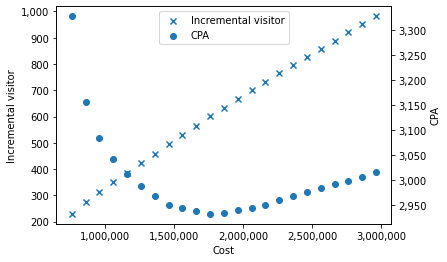

In [11]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:,.0f}'))
ax1.set_xlabel('Cost')
ax1.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc ='upper center')
plt.show()